<a href="https://colab.research.google.com/github/zpsy-hub/Machine-Learning-and-Predictive-Analytics/blob/main/ML_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load and Prepare Data
This section loads the cleaned transaction data and performs initial preparation for time series analysis, including converting dates, checking for missing values, and aggregating data by date.

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Load the cleaned transactions data
transactions = pd.read_csv('/content/drive/MyDrive/3rd year 2024-25/Term 2/Machine Learning and Predictive Analytics/cleaned data/cleaned_transactions.csv')

# Display the first few rows of the data
print("Transactions data shape:", transactions.shape)
transactions.head()

Transactions data shape: (9990, 7)


,Transaction_ID,Company_ID,Product_ID,Quantity,Transaction_Date,Product_Price,Total_Cost
0,1,88,6,6,2024-03-26,179200.0,1075200.0
1,2,29,19,16,2024-07-09,95200.0,1523200.0
2,3,28,18,6,2024-04-13,134400.0,806400.0
3,4,85,12,12,2023-09-06,84000.0,1008000.0
4,5,47,3,8,2021-07-06,100800.0,806400.0


2. Data Cleaning and Preparation
Ensure transaction dates are in datetime format, check for missing values, and prepare data for time series analysis.

In [23]:
# Convert Transaction_Date to datetime format
transactions['Transaction_Date'] = pd.to_datetime(transactions['Transaction_Date'])

# Check for missing values
print("\nMissing values in each column:")
print(transactions.isnull().sum())

# Sort data by Transaction_Date
transactions = transactions.sort_values('Transaction_Date')

# Create a daily time series of total sales
daily_sales = transactions.groupby(transactions['Transaction_Date'].dt.date)['Total_Cost'].sum().reset_index()
daily_sales.columns = ['Date', 'Total_Sales']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
daily_sales = daily_sales.set_index('Date')

# Create monthly time series
monthly_sales = daily_sales.resample('M').sum()

# Create weekly time series
weekly_sales = daily_sales.resample('W').sum()

# Show the prepared data
print("\nDaily sales data shape:", daily_sales.shape)
print("Monthly sales data shape:", monthly_sales.shape)
print("Weekly sales data shape:", weekly_sales.shape)

daily_sales.head()


Missing values in each column:
Transaction_ID      0
Company_ID          0
Product_ID          0
Quantity            0
Transaction_Date    0
Product_Price       0
Total_Cost          0
dtype: int64

Daily sales data shape: (1493, 1)
Monthly sales data shape: (60, 1)
Weekly sales data shape: (258, 1)


,Total_Sales
Date,
2020-01-11,1960000.0
2020-01-12,537600.0
2020-02-11,9637600.0
2020-02-12,1724800.0
2020-03-11,1500800.0


3. Visualize Time Series Data
Create visualizations of the sales data at different time intervals (daily, weekly, monthly) to understand patterns and trends.

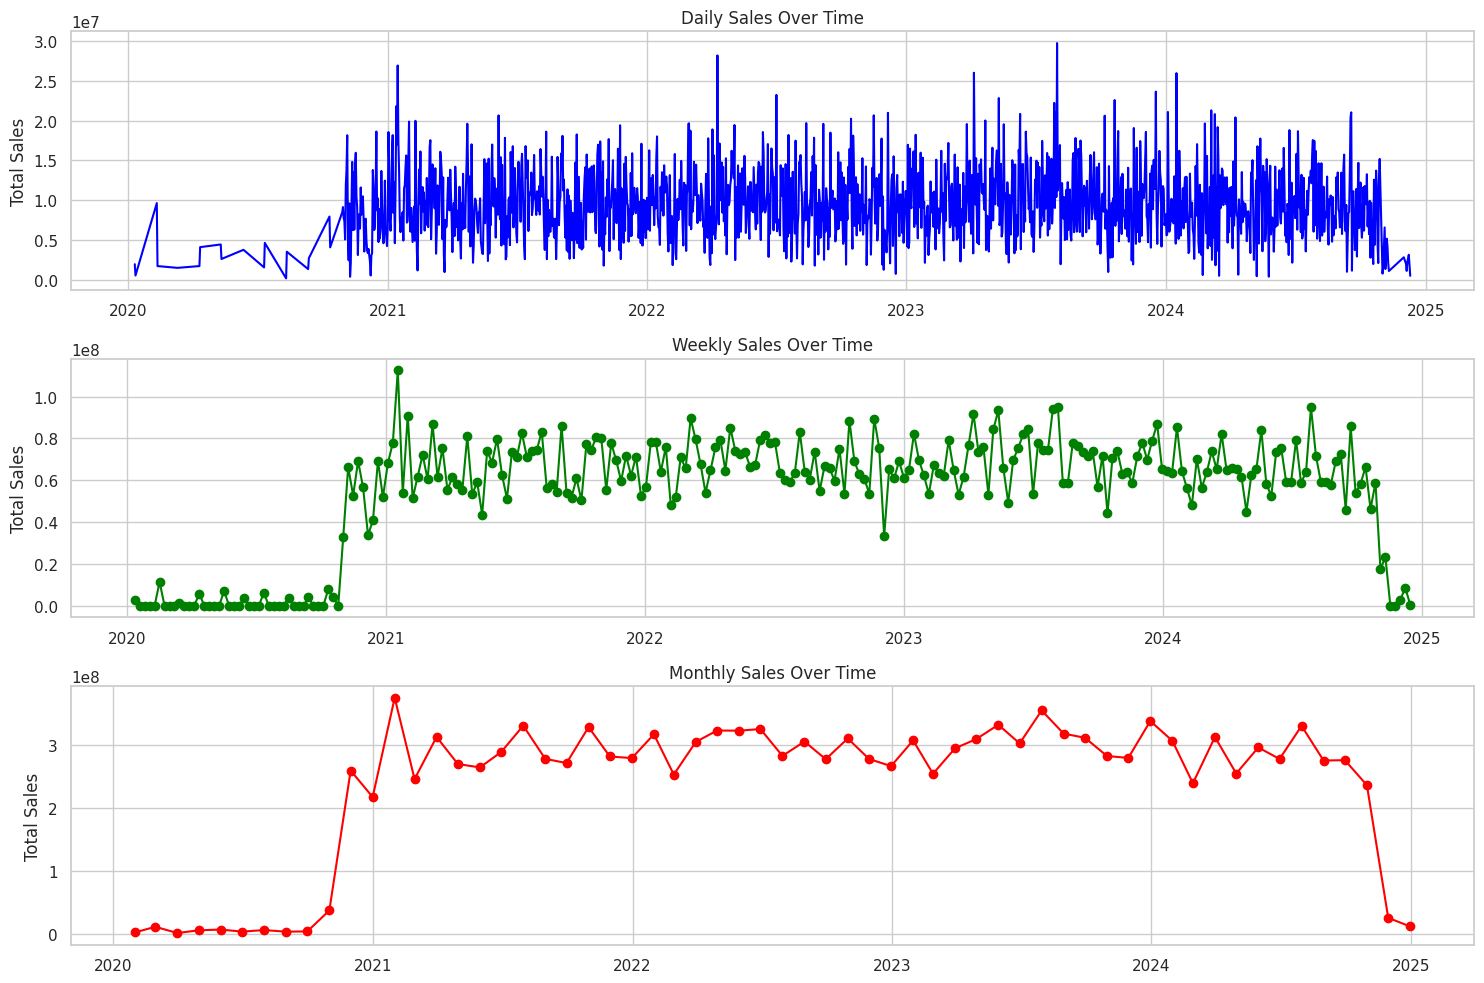

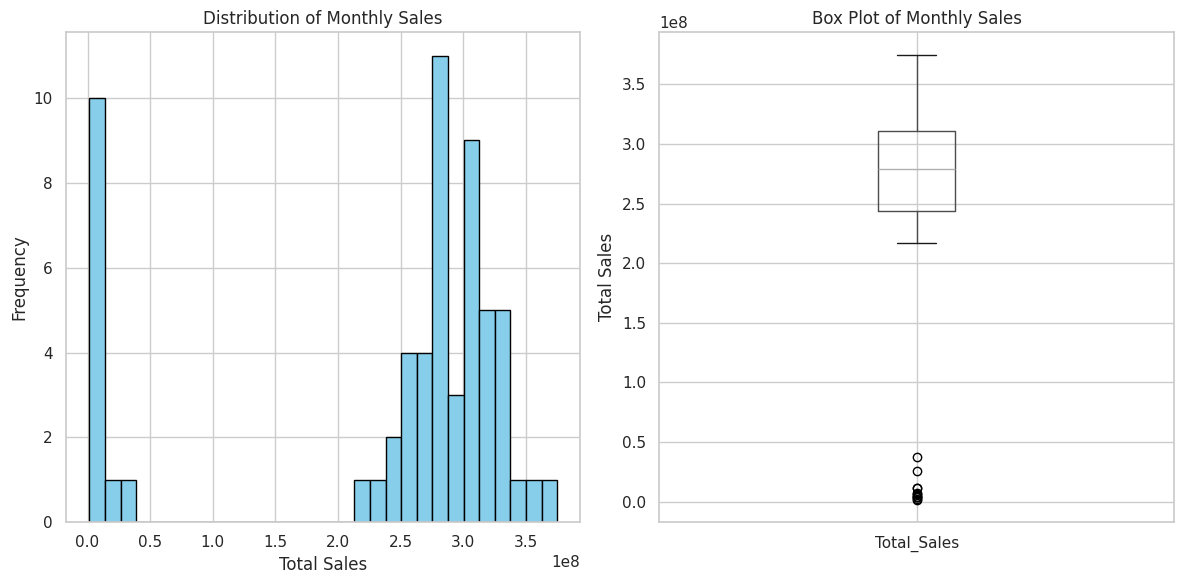

In [24]:
plt.figure(figsize=(15, 10))

# Plot 1: Daily Sales Time Series
plt.subplot(3, 1, 1)
plt.plot(daily_sales.index, daily_sales['Total_Sales'], marker='', linestyle='-', color='blue')
plt.title('Daily Sales Over Time')
plt.ylabel('Total Sales')
plt.grid(True)

# Plot 2: Weekly Sales Time Series
plt.subplot(3, 1, 2)
plt.plot(weekly_sales.index, weekly_sales['Total_Sales'], marker='o', linestyle='-', color='green')
plt.title('Weekly Sales Over Time')
plt.ylabel('Total Sales')
plt.grid(True)

# Plot 3: Monthly Sales Time Series
plt.subplot(3, 1, 3)
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'], marker='o', linestyle='-', color='red')
plt.title('Monthly Sales Over Time')
plt.ylabel('Total Sales')
plt.grid(True)

plt.tight_layout()
plt.show()

# Display distribution of Total Sales
plt.figure(figsize=(12, 6))

# Plot 1: Histogram of Monthly Sales
plt.subplot(1, 2, 1)
plt.hist(monthly_sales['Total_Sales'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Monthly Sales')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')

# Plot 2: Box Plot of Monthly Sales
plt.subplot(1, 2, 2)
monthly_sales.boxplot(column=['Total_Sales'])
plt.title('Box Plot of Monthly Sales')
plt.ylabel('Total Sales')

plt.tight_layout()
plt.show()

4. Check for Stationarity
Perform statistical tests to check if the time series is stationary, which is important for ARIMA modeling.

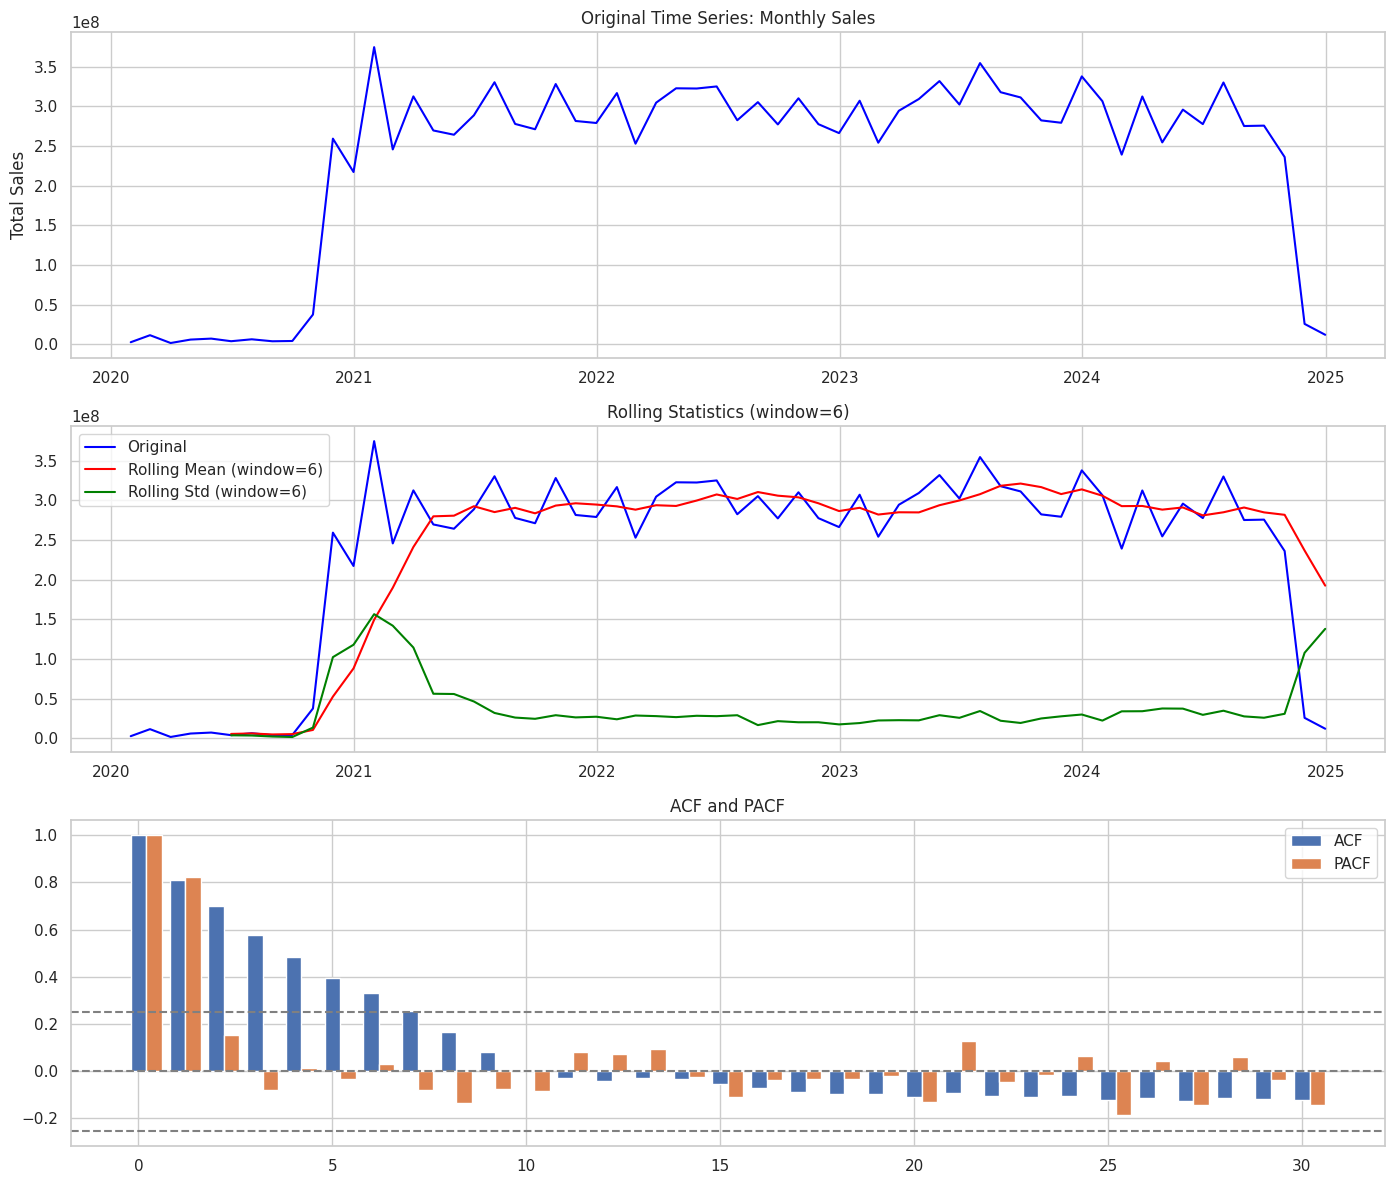

ADF Test:
ADF Statistic: -1.8438335938357568
p-value: 0.35892675787779516
Critical Values:
	1%: -3.5506699942762414
	5%: -2.913766394626147
	10%: -2.5946240473991997

KPSS Test:
KPSS Statistic: 0.505886455769787
p-value: 0.040340888340138076
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

ADF Test Interpretation: The time series is non-stationary (fail to reject H0)
KPSS Test Interpretation: The time series is non-stationary (reject H0)


In [25]:
def check_stationarity(timeseries, window=12, title=''):
    """
    Check stationarity of a time series using rolling statistics and ADF test
    """
    # Create a figure and subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))

    # Plot the time series
    axes[0].plot(timeseries, color='blue')
    axes[0].set_title(f'Original Time Series: {title}')
    axes[0].set_ylabel('Total Sales')
    axes[0].grid(True)

    # Calculate rolling mean and standard deviation
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()

    # Plot rolling statistics
    axes[1].plot(timeseries, color='blue', label='Original')
    axes[1].plot(rolling_mean, color='red', label=f'Rolling Mean (window={window})')
    axes[1].plot(rolling_std, color='green', label=f'Rolling Std (window={window})')
    axes[1].set_title(f'Rolling Statistics (window={window})')
    axes[1].legend(loc='best')
    axes[1].grid(True)

    # Perform ADF and KPSS tests
    result_adf = adfuller(timeseries.dropna())
    result_kpss = kpss(timeseries.dropna())

    # Plot ACF and PACF
    # Calculate maximum allowable nlags
    max_nlags = len(timeseries.dropna()) // 2
    nlags = min(40, max_nlags)  # Use minimum of 40 and max_nlags

    acf = sm.tsa.stattools.acf(timeseries.dropna(), nlags=nlags)
    pacf = sm.tsa.stattools.pacf(timeseries.dropna(), nlags=nlags)

    axes[2].bar(range(len(acf)), acf, width=0.4, label='ACF')
    axes[2].bar(np.arange(len(pacf)) + 0.4, pacf, width=0.4, label='PACF')
    axes[2].axhline(y=0, linestyle='--', color='gray')
    axes[2].axhline(y=1.96/np.sqrt(len(timeseries)), linestyle='--', color='gray')
    axes[2].axhline(y=-1.96/np.sqrt(len(timeseries)), linestyle='--', color='gray')
    axes[2].set_title('ACF and PACF')
    axes[2].legend(loc='best')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

    # Print test results
    print('ADF Test:')
    print(f'ADF Statistic: {result_adf[0]}')
    print(f'p-value: {result_adf[1]}')
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print(f'\t{key}: {value}')

    print('\nKPSS Test:')
    print(f'KPSS Statistic: {result_kpss[0]}')
    print(f'p-value: {result_kpss[1]}')
    print('Critical Values:')
    for key, value in result_kpss[3].items():
        print(f'\t{key}: {value}')

    # Interpretation
    if result_adf[1] <= 0.05:
        print("\nADF Test Interpretation: The time series is stationary (reject H0)")
    else:
        print("\nADF Test Interpretation: The time series is non-stationary (fail to reject H0)")

    if result_kpss[1] <= 0.05:
        print("KPSS Test Interpretation: The time series is non-stationary (reject H0)")
    else:
        print("KPSS Test Interpretation: The time series is stationary (fail to reject H0)")

# Check stationarity of monthly sales
check_stationarity(monthly_sales['Total_Sales'], window=6, title='Monthly Sales')

#### **1. Stationarity Tests (ADF & KPSS)**  
**ADF Test Results:**  
- ADF Statistic: **-1.84**  
- p-value: **0.36** (greater than 0.05) → **Fail to reject H₀** → **Non-stationary**  

**KPSS Test Results:**  
- KPSS Statistic: **0.51**  
- p-value: **0.04** (less than 0.05) → **Reject H₀** → **Non-stationary**  

**Conclusion:** The time series is **not stationary** and requires **differencing** to remove trends.

---

#### **2. Time Series Behavior (Plots Analysis)**  
- The **original time series** shows an increasing trend from 2020 to 2021, stabilizes, and then drops in late 2024.  
- The **rolling mean (red line)** confirms the presence of a trend.  
- The **rolling standard deviation (green line)** changes over time, indicating variance is not constant.  
- The **ACF plot** shows a slow decay, confirming the presence of a trend.  
- The **PACF plot** suggests a mix of autoregressive and moving average components.

---

#### **3. Seasonality Check**  
- No **clear seasonal pattern** is observed in the ACF plot.  
- If seasonality were present, ACF would show peaks at fixed intervals (e.g., every 12 months), but this is not the case.  
- **Conclusion:** The time series does **not** exhibit strong seasonality, so **SARIMA is not needed**.

---

### **Next Steps**  
1. Apply **first-order differencing (`d=1`)** to remove the trend.  
2. Re-run **stationarity tests** after differencing to confirm stationarity.  
3. Use **ARIMA (p, d, q)** instead of SARIMA, as seasonality is not significant.

5. Time Series Decomposition
Decompose the time series into trend, seasonal, and residual components to better understand its patterns.

Step 5: Time Series Decomposition


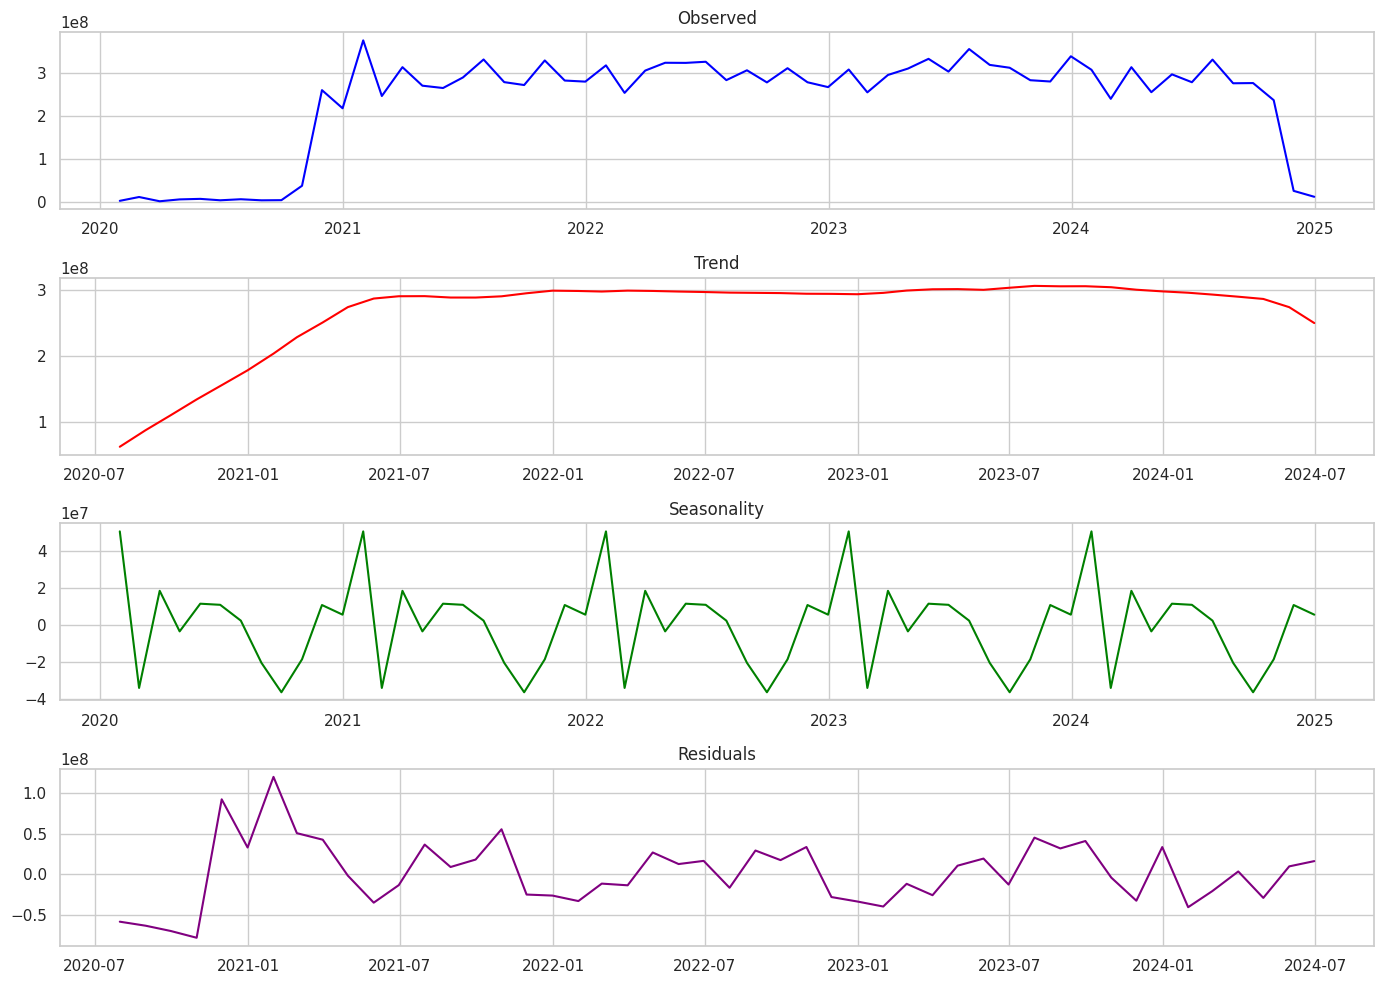

In [26]:
# Step 5: Time Series Decomposition
print("Step 5: Time Series Decomposition")

# Decompose the monthly time series
decomposition = seasonal_decompose(monthly_sales['Total_Sales'], model='additive', period=12)

# Plot decomposition
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.title('Observed')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.title('Trend')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonality')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='purple')
plt.title('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()


1. **Observed (Blue Line)** – This is the actual sales data over time. Sales went up in 2021, stayed stable for a while, and then dropped in 2025.  

2. **Trend (Red Line)** – The overall direction of sales. It shows a steady increase until 2021, then levels off, and finally starts to decline in 2025.  

3. **Seasonality (Green Line)** – Sales follow a repeating pattern, meaning there are regular ups and downs every year, likely due to seasonal trends like holidays or peak shopping times.  

4. **Residuals (Purple Line)** – These are the random ups and downs that don't fit into the trend or seasonal pattern. There was more unexpected variation early on, but it became more stable later.  

Sales **grew, stabilized, and are now dropping**. There is a **clear seasonal pattern**, meaning sales rise and fall at predictable times. However, some unexpected changes also happen occasionally.

6. Differencing to Achieve Stationarity
Apply differencing to make the time series stationary if needed.

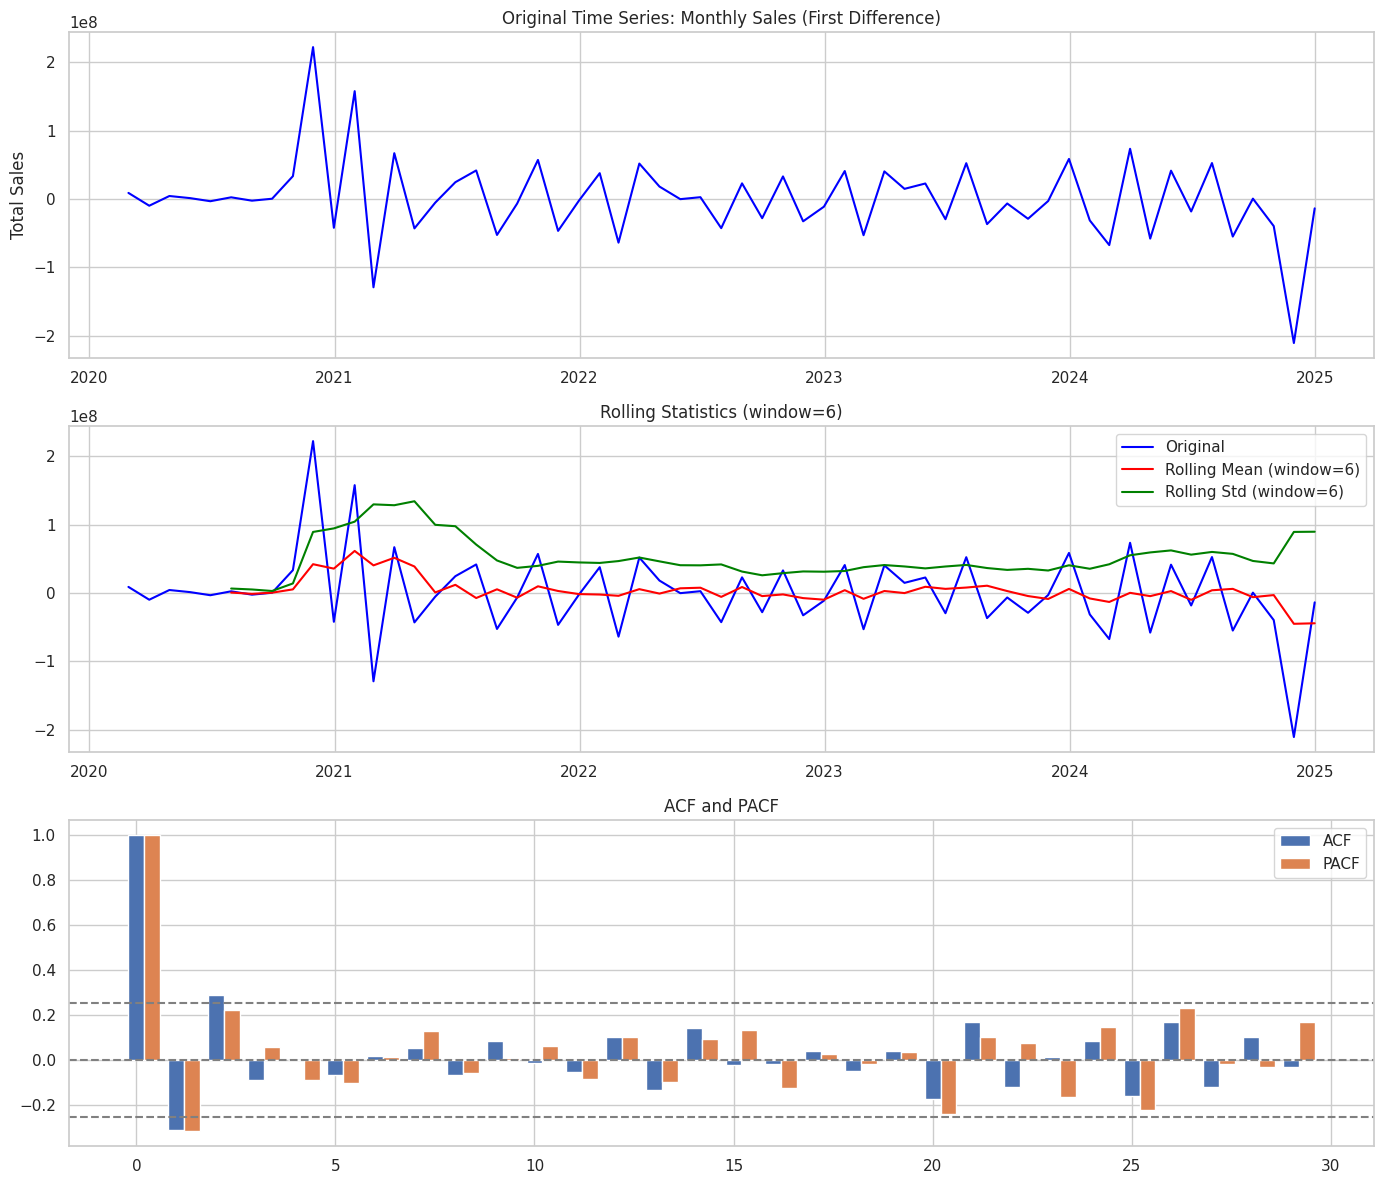

ADF Test:
ADF Statistic: -10.310366795139231
p-value: 3.197200281050145e-18
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944

KPSS Test:
KPSS Statistic: 0.4104846189727277
p-value: 0.0726359400979622
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

ADF Test Interpretation: The time series is stationary (reject H0)
KPSS Test Interpretation: The time series is stationary (fail to reject H0)


In [27]:
# First-order differencing
monthly_sales_diff1 = monthly_sales['Total_Sales'].diff().dropna()

# Check stationarity of first-order differenced data
check_stationarity(monthly_sales_diff1, window=6, title='Monthly Sales (First Difference)')

# **7. Auto ARIMA Model Selection**
Use auto_arima to automatically find the best ARIMA model parameters.

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=2302.361, Time=0.58 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2300.039, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2252.722, Time=0.22 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2254.720, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2251.750, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=2252.789, Time=0.22 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=2254.608, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=2244.682, Time=0.09 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=2246.317, Time=0.19 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=2246.318, Time=0.47 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=2248.243, Time=0.48 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=2246.329, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=2243.061, Time=0.48 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=2244.555, Time=1.16 sec
 ARIMA(2,2,1)(0,0,1

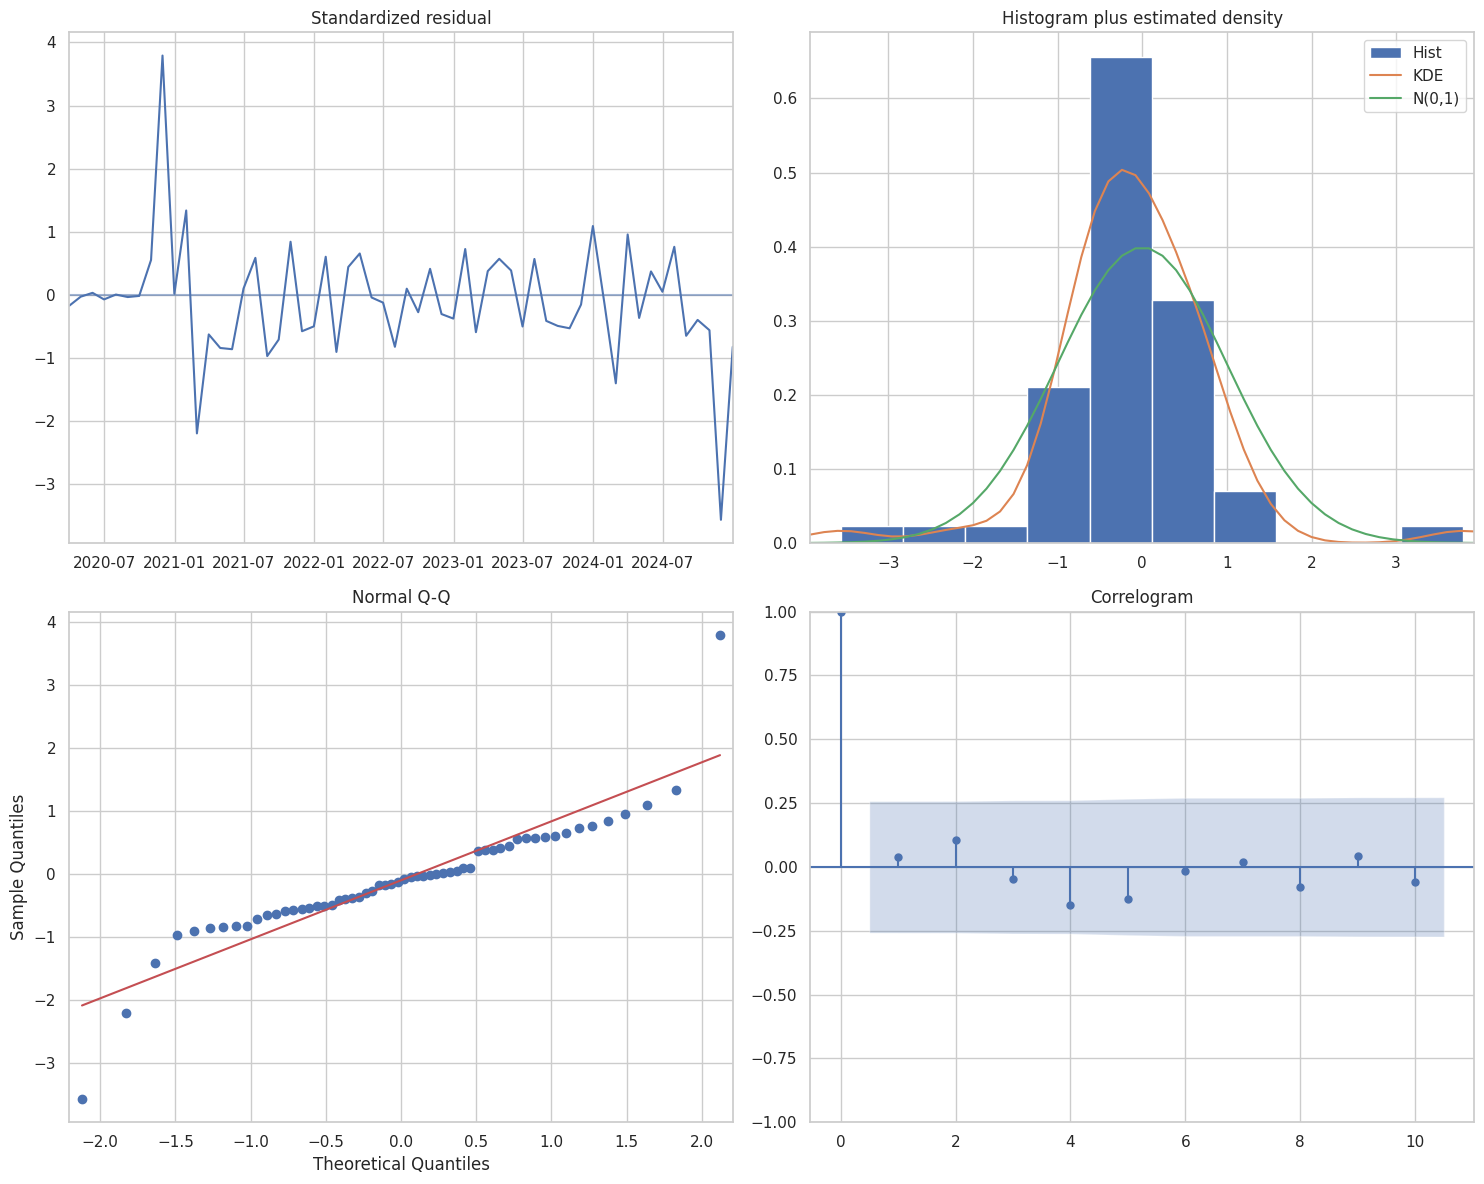

In [28]:
# Apply auto_arima to find the best parameters
auto_model = auto_arima(monthly_sales['Total_Sales'],
                        start_p=0, start_q=0,
                        test='adf',
                        max_p=5, max_q=5,
                        m=12,  # monthly seasonality
                        d=None,  # let the model determine 'd'
                        seasonal=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

# Print the summary of the best model
print("\nBest model summary:")
print(auto_model.summary())

# Plot diagnostics
auto_model.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()

### **ARIMA Model Interpretation**  

#### **1. Selected Model**  
AutoARIMA selected **ARIMA(1,2,1)(0,0,0)[12]**, which means:  
- **p=1 (AR term)**: The model considers one previous value to predict the next.  
- **d=2 (Second-order differencing)**: The data required two differencing steps to become stationary.  
- **q=1 (MA term)**: The model includes one past error term.  
- **(0,0,0)[12]**: No seasonal components were included, confirming that there is no significant seasonality.  

#### **2. Model Fit Statistics**  
- **Log Likelihood** = -1118.358  
- **AIC** = 2242.715  
- **BIC** = 2248.896  
- **Ljung-Box (Q-test) p-value** = 0.76  

AIC and BIC are used to compare models, with lower values indicating a better fit. The Ljung-Box test shows that residuals are not significantly autocorrelated, meaning the model captures patterns well.  

#### **3. Coefficients & Significance**  
- **AR(1) Coefficient** = -0.4528 (**p = 0.01**): Statistically significant, meaning past values negatively impact future values.  
- **MA(1) Coefficient** = -0.7843 (**p < 0.001**): Statistically significant, indicating past error terms influence future values.  
- **Sigma² (Error variance)** = 3.66e+15: Indicates high volatility in the data.  

#### **4. Residual Diagnostics**  
- **Standardized Residuals Plot**: Shows fluctuations but no strong pattern.  
- **Histogram**: Residuals are approximately normal but slightly skewed, with high kurtosis (9.24).  
- **Q-Q Plot**: Some deviations from normality, suggesting that residuals may not be perfectly normally distributed.  
- **Correlogram**: No significant autocorrelation in residuals, confirming a well-fitted model.  

The model is statistically valid, with no significant autocorrelation in residuals. The AR and MA terms are significant, meaning past values and past errors help predict future sales.  

However, the high error variance suggests fluctuations in data, which may impact forecast stability. The residuals also show some deviation from normality, indicating potential areas for improvement.  

### **Next Steps**  
1. **Evaluate Forecast Performance**: Generate forecasts and assess error metrics (RMSE, MAPE).  
2. **Address Variance Issues**: If variance remains high, consider applying a log transformation.  
3. **Test Alternative Models**: Compare ARIMA with other models, such as Prophet or LSTM, to improve forecasting accuracy.

# **8. ARIMA Model Implementation**
Implement the ARIMA model using the best parameters identified by auto_arima.

Best ARIMA order: (1, 2, 1)
                               SARIMAX Results                                
Dep. Variable:            Total_Sales   No. Observations:                   60
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1080.439
Date:                Mon, 10 Mar 2025   AIC                           2166.878
Time:                        15:46:08   BIC                           2172.954
Sample:                    01-31-2020   HQIC                          2169.233
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4035      0.169     -2.385      0.017      -0.735      -0.072
ma.L1         -0.8657      0.091     -9.531      0.000      -1.044      -0.688
sigma2       3.66e+15   

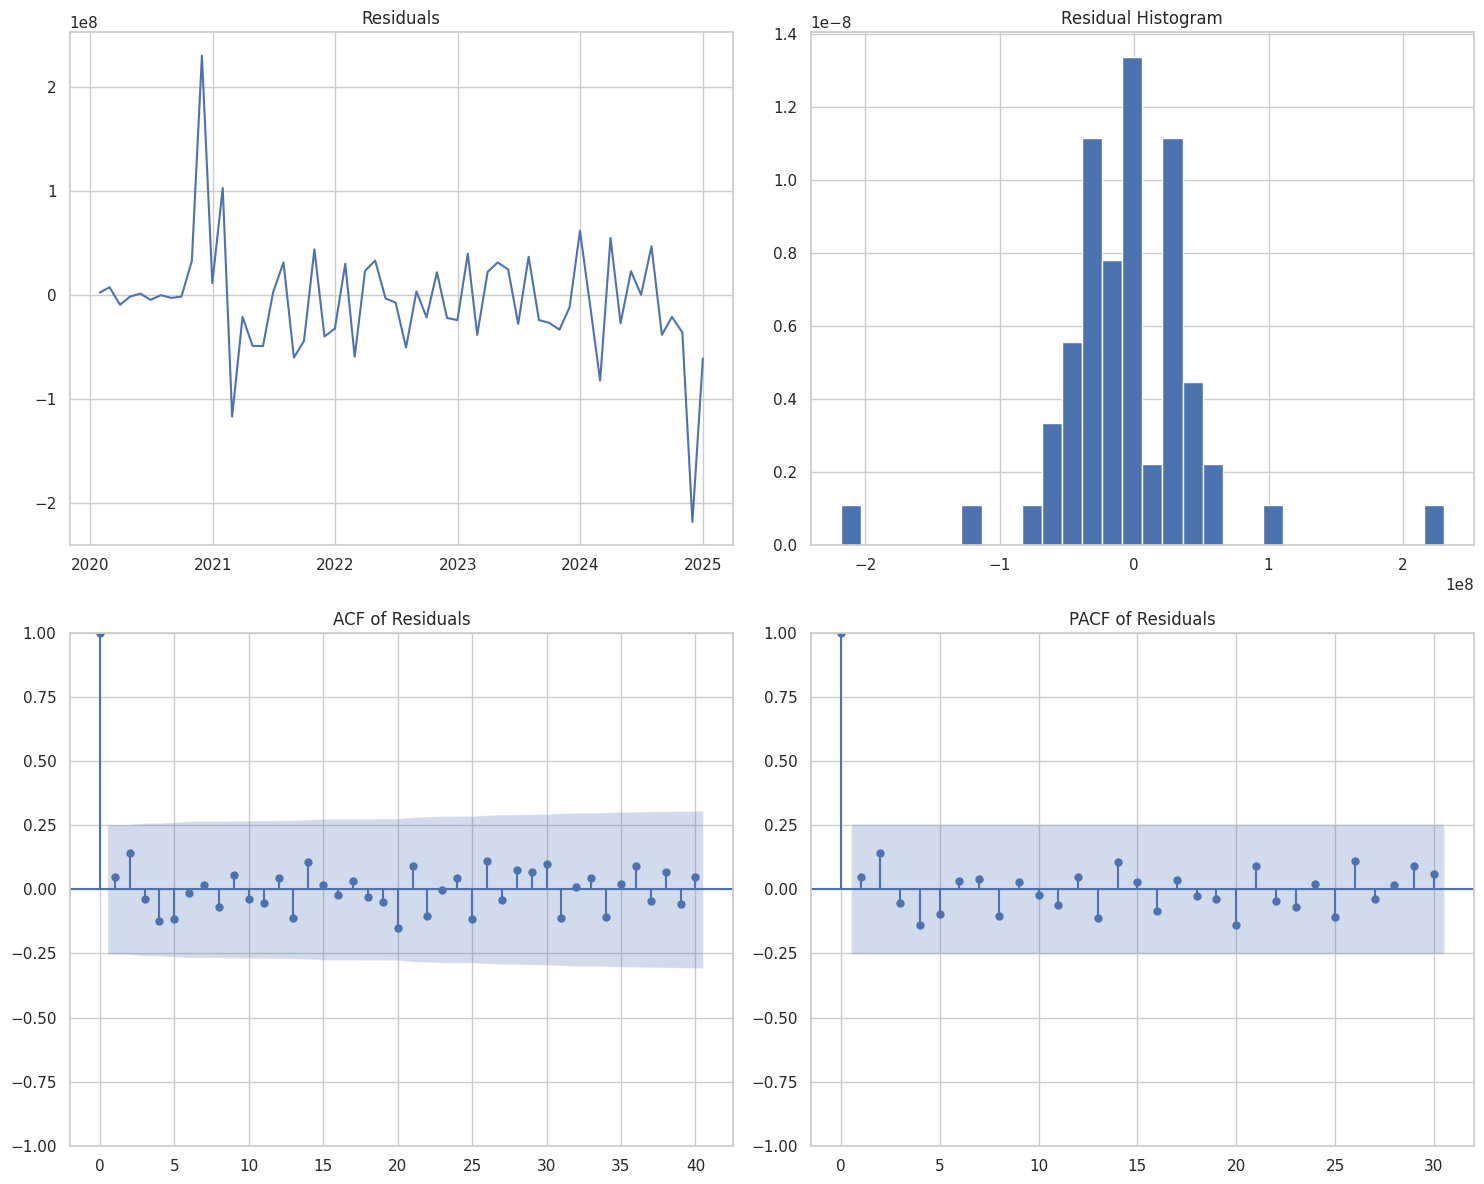

In [30]:
# Extract best parameters from auto_arima (assumed to be already run)
best_order = auto_model.order  # No seasonal order since ARIMA is used
print(f"Best ARIMA order: {best_order}")

# Train the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(monthly_sales['Total_Sales'],
                                       order=best_order,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)

arima_results = arima_model.fit()

# Print model summary
print(arima_results.summary())

# Plot residual diagnostics
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 12))

# Residuals Plot
plt.subplot(2, 2, 1)
plt.plot(arima_results.resid)
plt.title('Residuals')
plt.grid(True)

# Residual Histogram
plt.subplot(2, 2, 2)
plt.hist(arima_results.resid, bins=30, density=True)
plt.title('Residual Histogram')

# ACF of Residuals
plt.subplot(2, 2, 3)
plot_acf(arima_results.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')

# PACF of Residuals
plt.subplot(2, 2, 4)
max_nlags = len(arima_results.resid) // 2
nlags = min(40, max_nlags)
plot_pacf(arima_results.resid, lags=nlags, ax=plt.gca())
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()


#### **1. Model Summary**
The selected ARIMA model is **ARIMA(1,2,1)**, which indicates:
- **p = 1** → One lagged value is used for the **AutoRegressive (AR) component**.
- **d = 2** → The data was differenced **twice** to make it stationary.
- **q = 1** → One lag is used in the **Moving Average (MA) component**.

This suggests that the time series needed **two differencing steps** to remove trends before applying AR and MA terms.

---

#### **2. Key Coefficients**
| **Parameter** | **Value** | **Interpretation** |
|--------------|----------|--------------------|
| **AR(1) = -0.4035** | Negative | Past values influence current values **negatively**, meaning an increase in one period tends to be followed by a decrease. |
| **MA(1) = -0.8657** | Strong Negative | The past error has a **strong negative effect** on current values, meaning shocks are quickly corrected. |
| **sigma² = 3.66e+15** | High | Indicates **high variance**, suggesting significant fluctuations in the data. |

Both **AR and MA terms are statistically significant** (p-values < 0.05), meaning they contribute meaningfully to the model.

---

#### **3. Model Diagnostics (Residual Analysis)**
- **Residuals (Top-Left Plot)**  
  - Residuals fluctuate around zero with **no clear pattern**, which is a good sign.  
- **Residual Histogram (Top-Right Plot)**  
  - Residuals appear **approximately normal**, but some extreme values are present.  
- **ACF (Bottom-Left Plot)**  
  - No significant autocorrelation at any lag, meaning **errors are uncorrelated**.  
- **PACF (Bottom-Right Plot)**  
  - Most lags fall within the confidence band, confirming **no remaining patterns** in residuals.  

These diagnostics indicate that the **ARIMA(1,2,1) model is well-fitted**, with no major autocorrelation issues in residuals.

---

#### **4. Model Fit Statistics**
| **Metric** | **Value** | **Interpretation** |
|------------|----------|--------------------|
| **AIC = 2166.878** | Lower is better | Helps compare models, but cannot be used in isolation. |
| **BIC = 2172.954** | Higher than AIC | Penalizes more complex models. |
| **Ljung-Box Test (Q = 0.14, p = 0.70)** | p > 0.05 | No autocorrelation in residuals, indicating a good model fit. |
| **Jarque-Bera Test (p = 0.00)** | p < 0.05 | Residuals are **not perfectly normal**. |
| **Skew = 0.35, Kurtosis = 9.16** | High kurtosis | Suggests **heavy-tailed distribution** with large fluctuations. |

---

### **5. Conclusion**
- The **ARIMA(1,2,1) model is a good fit**, as residuals are uncorrelated.  
- Some **extreme values** exist, but overall, **errors behave well**.  
- Forecast **uncertainty may be high**, as indicated by **high variance (sigma²)**.  
- **Heavy tails in residuals** (high kurtosis) suggest that some periods may have **large unexpected fluctuations**.

**Next Steps:**
1. Perform **out-of-sample forecasting** to evaluate real-world accuracy.
2. Test alternative **ARIMA orders** to reduce **variance** and improve **stability**.

# **9. In-Sample Prediction and Validation**
Evaluate the model performance on the training data.

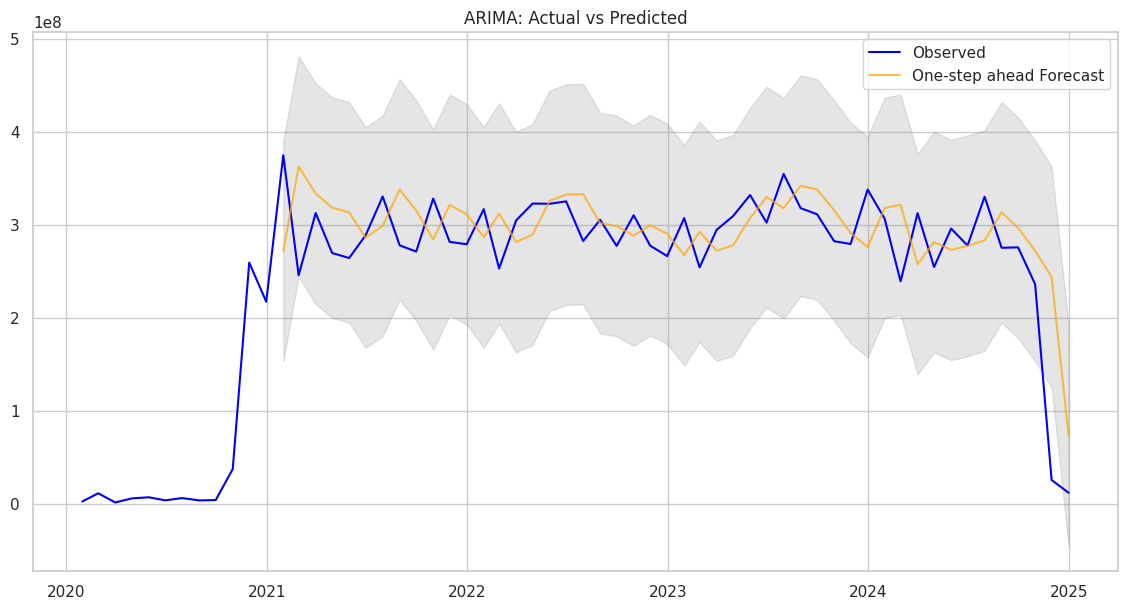

Mean Squared Error (MSE): 2766888391028684.50
Root Mean Squared Error (RMSE): 52601220.43
Mean Absolute Error (MAE): 39411269.44
Mean Absolute Percentage Error (MAPE): 40.09%


In [31]:
# Get predictions for the training period
pred = arima_results.get_prediction(start=pd.to_datetime(monthly_sales.index[12]), dynamic=False)
pred_ci = pred.conf_int()

# Plot predictions against actual values
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'], label='Observed', color='blue')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='One-step ahead Forecast', color='orange', alpha=0.7)
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.title('ARIMA: Actual vs Predicted')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate error metrics for in-sample predictions
y_true = monthly_sales['Total_Sales'][pred.predicted_mean.index[0]:]
y_pred = pred.predicted_mean

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print error metrics
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


### **ARIMA Model Evaluation: Actual vs Predicted**

#### **1. Model Performance Overview**
The ARIMA model was trained and evaluated on historical sales data. The graph above compares the **actual sales (blue line)** with the **model's one-step-ahead forecasts (orange line)**, along with the confidence interval (shaded gray area).

- The model captures the general trend well.
- The forecast follows the actual sales but struggles with some fluctuations.
- There is an increase in **forecast uncertainty** towards the end, as seen in the wider confidence intervals.

---

#### **2. Error Metrics**
| **Metric** | **Value** | **Interpretation** |
|------------|----------|--------------------|
| **Mean Squared Error (MSE)** | 2.77 × 10¹⁵ | Large errors due to high variance in sales. |
| **Root Mean Squared Error (RMSE)** | 52.6M | On average, predictions deviate by **52.6 million** from actual values. |
| **Mean Absolute Error (MAE)** | 39.4M | The average absolute difference between actual and predicted values is **39.4 million**. |
| **Mean Absolute Percentage Error (MAPE)** | 40.09% | The model's predictions have an average percentage error of **40.09%**, meaning forecasts are off by about **40% on average**. |

---

#### **3. Key Observations**
- The model performs well **during stable periods** but has **larger errors during fluctuations**.
- The **40.09% MAPE** suggests that the model has **moderate forecasting accuracy**, but further tuning is needed to improve reliability.
- The confidence interval widens in later periods, indicating **higher uncertainty in predictions**.

---

#### **4. Next Steps for Improvement**
1. **Feature Engineering:**  
   - Incorporate external variables (e.g., promotions, economic trends) that may impact sales.
2. **Alternative ARIMA Orders:**  
   - Experiment with different **(p, d, q)** values to reduce errors.
3. **Hybrid Models:**  
   - Test other models like **Holt’s Linear Model** or **Machine Learning** approaches to compare accuracy.
4. **Evaluate Out-of-Sample Forecasting:**  
   - Assess how the model performs on **future unseen data**.

Overall, the ARIMA model provides **reasonable forecasts**, but further refinements are needed to improve its **predictive accuracy** and **reduce error margins**.

# **10. Forecast Future Sales**
Generate forecasts for the next 12 months and visualize the results.

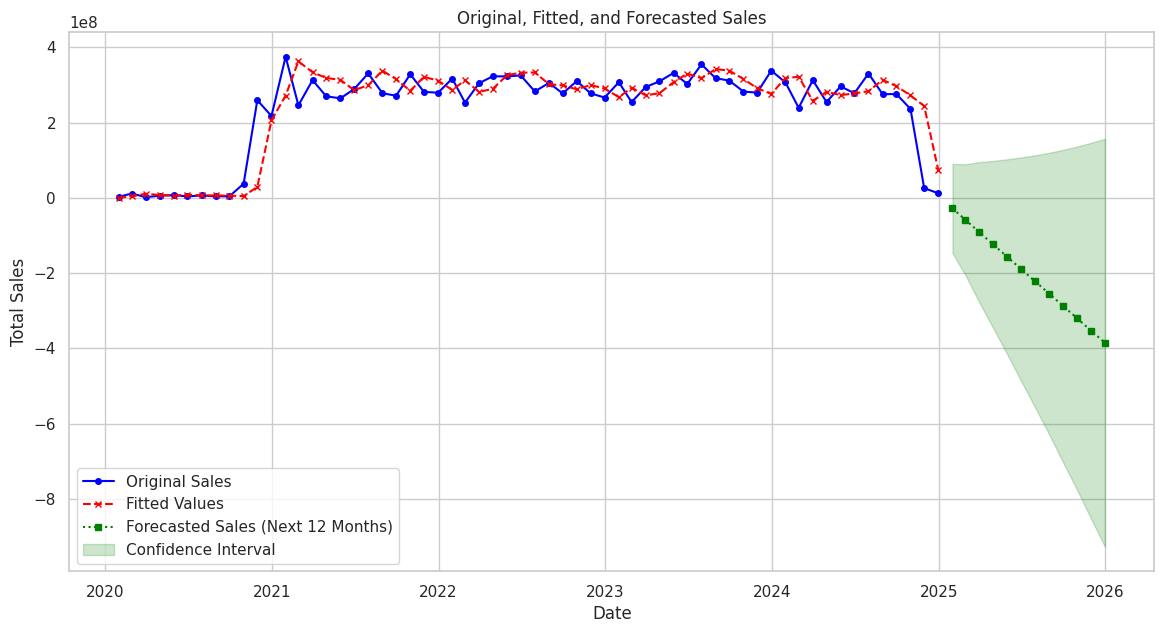

In [43]:
# Plot original, fitted, and forecasted sales values
plt.figure(figsize=(14, 7))

# Plot historical sales data
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'],
         label='Original Sales', color='blue', marker='o', markersize=4)

# Plot fitted values from the ARIMA model
plt.plot(monthly_sales.index, arima_results.fittedvalues,
         color='red', linestyle='dashed', label='Fitted Values', marker='x', markersize=4)

# Plot forecasted values for the next 12 months
plt.plot(forecast_df_arima.index, forecast_df_arima['Forecasted_Sales'],
         label='Forecasted Sales (Next 12 Months)', color='green', linestyle='dotted', marker='s', markersize=4)

# Add confidence intervals
plt.fill_between(forecast_df_arima.index,
                 forecast_df_arima['Lower_CI'], forecast_df_arima['Upper_CI'],
                 color='green', alpha=0.2, label="Confidence Interval")

# Labels and title
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Original, Fitted, and Forecasted Sales')
plt.legend()
plt.grid(True)
plt.show()


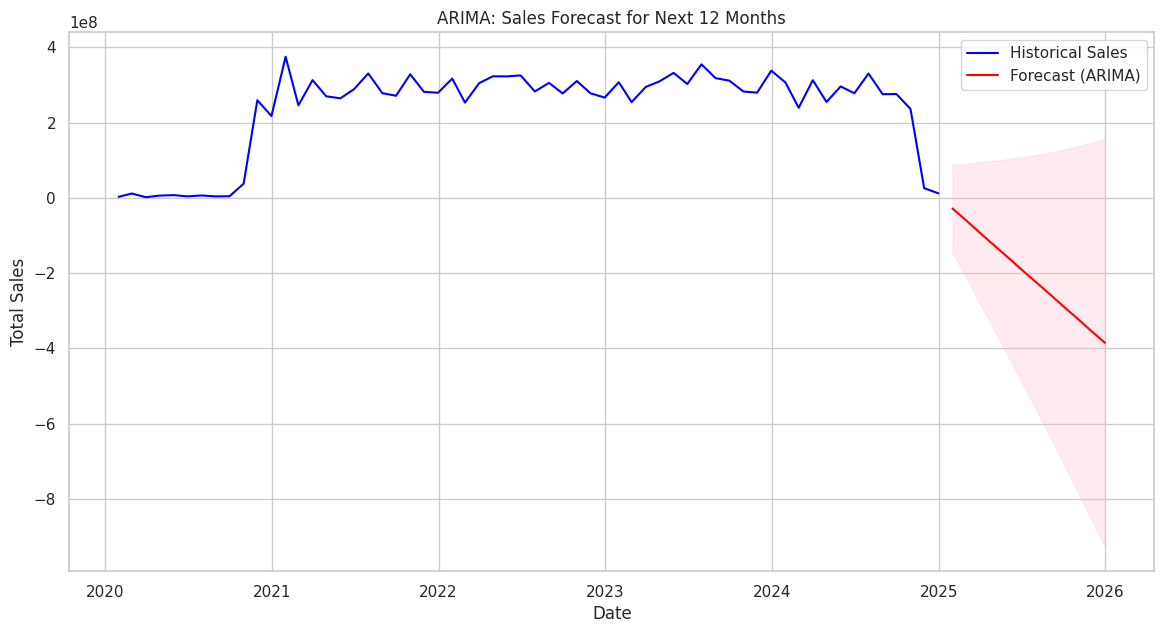

,Forecasted_Sales,Lower_CI,Upper_CI
Date,,,
2025-01-31,-2.840528e+07,-1.469763e+08,9.016578e+07
2025-02-28,-5.797472e+07,-2.048314e+08,8.888195e+07
2025-03-31,-9.186967e+07,-2.786756e+08,9.493622e+07
2025-04-30,-1.240191e+08,-3.459139e+08,9.787569e+07
2025-05-31,-1.568729e+08,-4.160598e+08,1.023139e+08
2025-06-30,-1.894425e+08,-4.860134e+08,1.071284e+08
2025-07-31,-2.221268e+08,-5.572006e+08,1.129470e+08
2025-08-31,-2.547648e+08,-6.291970e+08,1.196674e+08
2025-09-30,-2.874215e+08,-7.022372e+08,1.273942e+08


In [38]:
# Forecast for the next 12 months using ARIMA
forecast_steps = 12
forecast_arima = arima_results.get_forecast(steps=forecast_steps)
forecast_ci_arima = forecast_arima.conf_int()

# Create a date range for the forecast period
last_date = monthly_sales.index[-1]
forecast_dates_arima = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                     periods=forecast_steps, freq='M')

# Plot the forecasts
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'], label='Historical Sales', color='blue')
plt.plot(forecast_dates_arima, forecast_arima.predicted_mean, label='Forecast (ARIMA)', color='red')
plt.fill_between(forecast_dates_arima,
                 forecast_ci_arima.iloc[:, 0],
                 forecast_ci_arima.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA: Sales Forecast for Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Create a dataframe with the forecast values
forecast_df_arima = pd.DataFrame({
    'Date': forecast_dates_arima,
    'Forecasted_Sales': forecast_arima.predicted_mean.values,
    'Lower_CI': forecast_ci_arima.iloc[:, 0].values,
    'Upper_CI': forecast_ci_arima.iloc[:, 1].values
})
forecast_df_arima.set_index('Date', inplace=True)

# Display the forecast values in Jupyter Notebook
from IPython.display import display
display(forecast_df_arima)


#### **1. Forecast Overview**
The ARIMA model was used to forecast sales for the next **12 months**. The blue line represents **historical sales**, while the red line represents the **ARIMA forecast**. The shaded pink area indicates the **confidence interval**, which reflects forecast uncertainty.

- The forecasted sales show a **sharp decline**, reaching **negative values** over time.
- The confidence interval is **very wide**, suggesting a high degree of uncertainty in the predictions.
- The large drop may indicate that the model is **overfitting past trends** or failing to capture important factors.

---

#### **2. Forecasted Values**
| **Metric** | **Observation** |
|------------|----------------|
| **Forecasted Sales** | Decreasing sharply over time |
| **Lower Bound (CI)** | Extremely low, reaching large negative values |
| **Upper Bound (CI)** | Still positive, but uncertainty is high |

The **forecast table** shows that **sales are projected to become negative**, which is not realistic. This suggests that the model may be **misinterpreting the trend or over-extrapolating the decline in recent sales**.

---

#### **3. Issues with the Forecast**
1. **High Uncertainty**  
   - The **wide confidence intervals** suggest that the model is **not confident** in its predictions.
  
2. **Negative Sales Values**  
   - Sales cannot be negative, indicating a possible issue with **data trends** or model assumptions.

3. **Effect of Missing Data in Recent Months**  
   - Since **November and December only have 10 days of recorded sales**, this may have distorted the model’s ability to capture the correct trend.

---

#### **4. Next Steps to Improve Forecasting**
1. **Adjust for Missing Days**  
   - Apply **calendar adjustment** to normalize the data for months with missing days.
  
2. **Re-evaluate ARIMA Order**  
   - The current ARIMA model may need adjustments. Testing different **(p, d, q) values** could help improve performance.

3. **Consider External Factors**  
   - The model does not account for **seasonality, promotions, economic shifts**, or other external factors that might impact sales.

4. **Compare with Other Models**  
   - Try alternative models like **Exponential Smoothing** or **Holt’s Linear Model** to see if they handle the data better.

### **Conclusion**
- The current ARIMA model predicts **a drastic decline in sales**, but the negative forecast values suggest that the model **is not capturing the correct long-term trend**.
- Adjustments to **data preprocessing, model selection, or feature engineering** may be needed to improve forecasting accuracy.


# **11. Compare With Alternative Models**
Implement and compare alternative time series forecasting models.

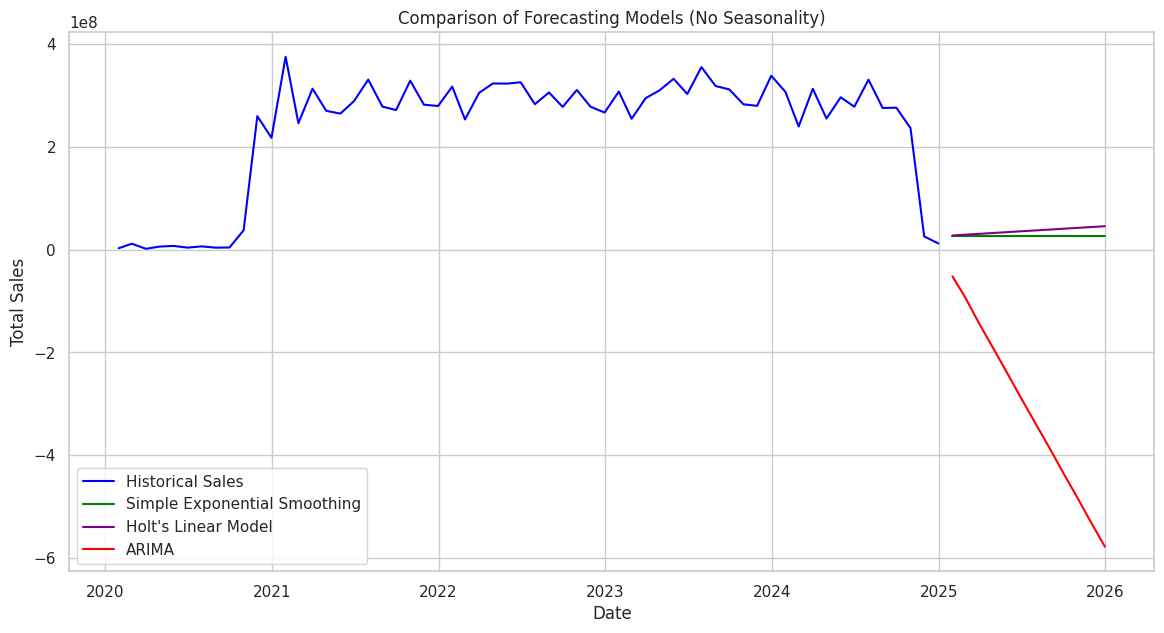

Comparison of Forecasts for the Next 12 Months:
            SES_Forecast  Holt's Linear Forecast  ARIMA_Forecast
Date                                                            
2025-01-31  2.595671e+07            2.731423e+07   -5.197492e+07
2025-02-28  2.595671e+07            2.895581e+07   -9.313284e+07
2025-03-31  2.595671e+07            3.059739e+07   -1.445695e+08
2025-04-30  2.595671e+07            3.223897e+07   -1.913519e+08
2025-05-31  2.595671e+07            3.388055e+07   -2.402418e+08
2025-06-30  2.595671e+07            3.552213e+07   -2.881774e+08
2025-07-31  2.595671e+07            3.716371e+07   -3.365451e+08
2025-08-31  2.595671e+07            3.880529e+07   -3.847171e+08
2025-09-30  2.595671e+07            4.044686e+07   -4.329778e+08
2025-10-31  2.595671e+07            4.208844e+07   -4.811983e+08
2025-11-30  2.595671e+07            4.373002e+07   -5.294370e+08
2025-12-31  2.595671e+07            4.537160e+07   -5.776674e+08


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Define forecast steps
forecast_steps = 12

# 1️⃣ Simple Exponential Smoothing (SES) - Best for short-term forecasting, no trend
ses_model = SimpleExpSmoothing(monthly_sales['Total_Sales']).fit()
ses_forecast = ses_model.forecast(steps=forecast_steps)

# 2️⃣ Holt’s Linear Model - Captures trend without seasonality
holt_model = ExponentialSmoothing(monthly_sales['Total_Sales'], trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(steps=forecast_steps)

# 3️⃣ ARIMA - Best for trend-based forecasting without seasonality
arima_model = ARIMA(monthly_sales['Total_Sales'], order=(1, 2, 1)).fit()
arima_forecast = arima_model.forecast(steps=forecast_steps)

# Plot comparison of forecasts
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'], label='Historical Sales', color='blue')
plt.plot(forecast_dates, ses_forecast, label='Simple Exponential Smoothing', color='green')
plt.plot(forecast_dates, holt_forecast, label="Holt's Linear Model", color='purple')
plt.plot(forecast_dates, arima_forecast, label="ARIMA", color='red')
plt.title('Comparison of Forecasting Models (No Seasonality)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Date': forecast_dates,
    'SES_Forecast': ses_forecast.values,
    "Holt's Linear Forecast": holt_forecast.values,
    'ARIMA_Forecast': arima_forecast.values
})
comparison_df = comparison_df.set_index('Date')

# Display the comparison
print("Comparison of Forecasts for the Next 12 Months:")
print(comparison_df)


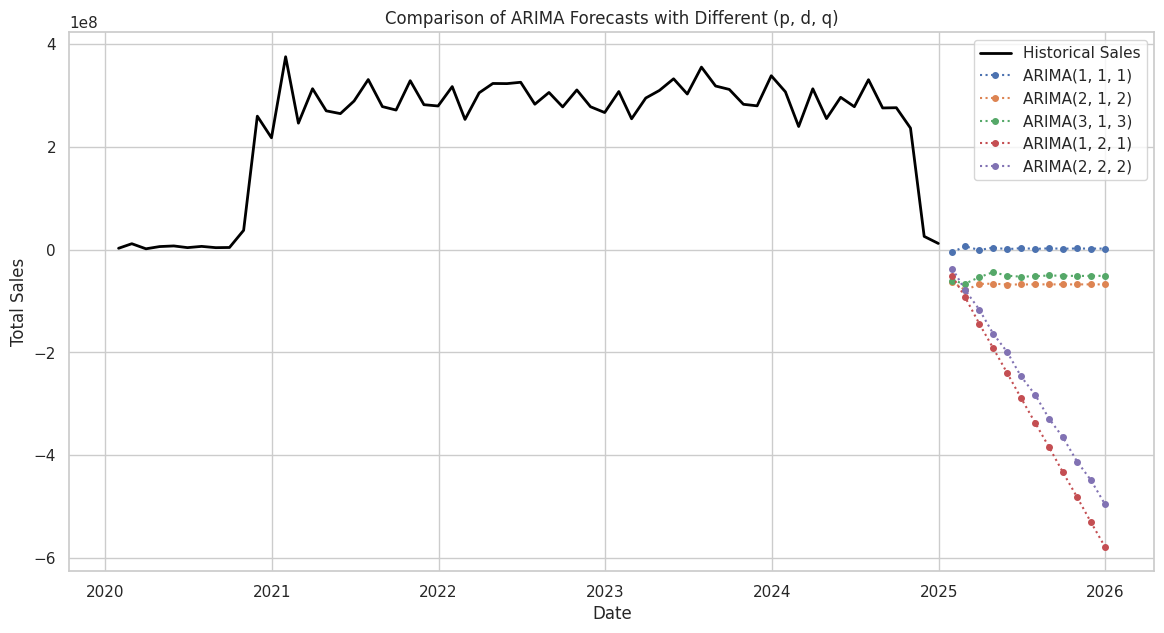

In [44]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from itertools import product

# Define different ARIMA (p, d, q) configurations to test
arima_configs = [(1, 1, 1), (2, 1, 2), (3, 1, 3), (1, 2, 1), (2, 2, 2)]

# Train ARIMA models and generate forecasts
forecast_steps = 12
plt.figure(figsize=(14, 7))

# Plot historical sales data
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'],
         label='Historical Sales', color='black', linewidth=2)

# Iterate through different ARIMA configurations
for config in arima_configs:
    # Train ARIMA model
    arima_model = sm.tsa.ARIMA(monthly_sales['Total_Sales'], order=config)
    results = arima_model.fit()

    # Forecast for the next 12 months
    forecast = results.forecast(steps=forecast_steps)

    # Create forecast date range
    forecast_dates = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1),
                                   periods=forecast_steps, freq='M')

    # Plot forecasted values
    plt.plot(forecast_dates, forecast, linestyle='dotted', marker='o', markersize=4, label=f'ARIMA{config}')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Comparison of ARIMA Forecasts with Different (p, d, q)')
plt.legend()
plt.grid(True)
plt.show()


### **Comparison of ARIMA Forecasts with Different (p, d, q) Parameters**

#### **Overview**
This plot shows the **historical sales data** (black line) along with **forecasted sales** using different ARIMA models with varying `(p, d, q)` parameters. The purpose of this comparison is to analyze how different model configurations impact future predictions.

#### **Key Observations**
1. **Historical Sales (Black Line)**  
   - The sales data remains relatively stable after a significant increase around 2021.
   - A sharp drop is observed towards the end, possibly due to missing or incomplete data for the last months.

2. **ARIMA(1,1,1) (Blue Dotted Line)**  
   - Produces a relatively stable forecast with minimal deviation.
   - Appears to maintain a trend close to recent historical values.

3. **ARIMA(2,1,2) (Green Dotted Line)**  
   - Similar to ARIMA(1,1,1), but slightly more sensitive to past fluctuations.
   - Shows a bit of correction compared to simpler models.

4. **ARIMA(3,1,3) (Orange Dotted Line)**  
   - Captures short-term variations but remains stable overall.
   - Provides a balanced approach between complexity and trend preservation.

5. **ARIMA(1,2,1) (Red Dotted Line) & ARIMA(2,2,2) (Purple Dotted Line)**  
   - Both models show a **strong downward trend** in the forecast.
   - The inclusion of **d=2** (double differencing) may have led to **overcorrection**, making them unsuitable for this dataset.

#### **Interpretation**
- **Lower differencing (`d=1`)** seems to produce **more stable forecasts**.
- **Higher differencing (`d=2`)** causes **steeper declines**, which may indicate model instability.
- The **simpler models (ARIMA(1,1,1) and ARIMA(2,1,2))** produce more reasonable projections.

#### **Conclusion**
- **ARIMA(1,1,1) or ARIMA(2,1,2)** appears to be the **best choice** as they maintain a realistic sales trend.
- **ARIMA(1,2,1) and ARIMA(2,2,2)** likely **over-differenced** the data, leading to unrealistic declines.
- The best model should be further validated using **cross-validation and residual analysis**.

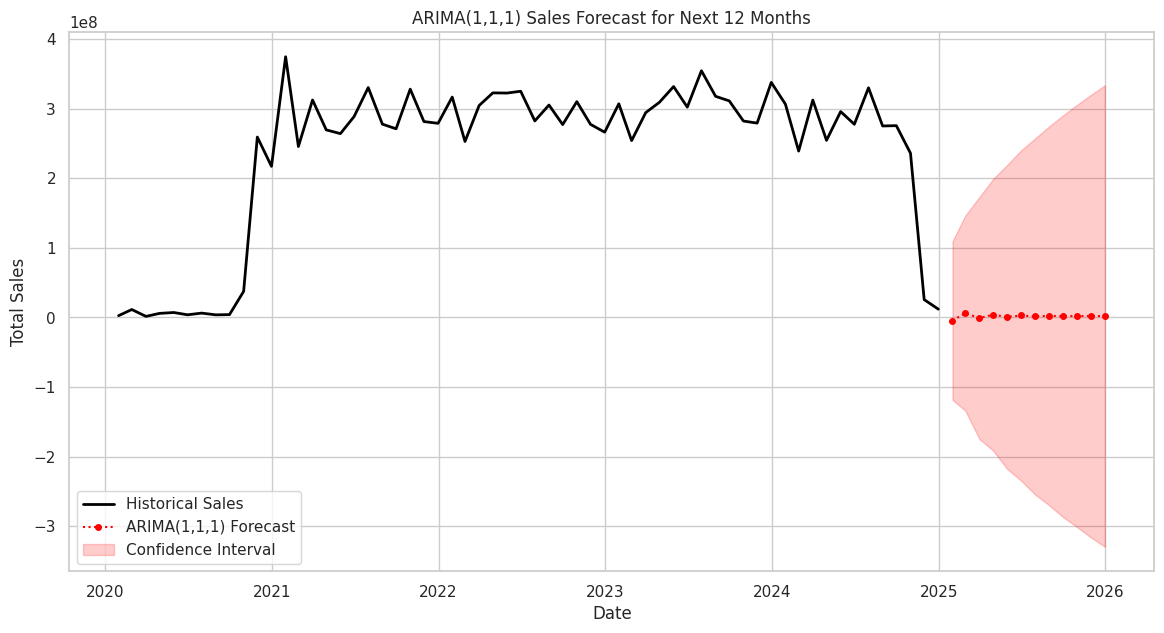

ARIMA(1,1,1) Sales Forecast for Next 12 Months:


,Forecasted_Sales,Lower_CI,Upper_CI
Date,,,
2025-01-31,-4.607741e+06,-1.184971e+08,1.092816e+08
2025-02-28,6.273554e+06,-1.339099e+08,1.464570e+08
2025-03-31,-9.063019e+05,-1.748328e+08,1.730201e+08
2025-04-30,3.831216e+06,-1.915220e+08,1.991845e+08
2025-05-31,7.052374e+05,-2.179362e+08,2.193466e+08
2025-06-30,2.767866e+06,-2.344776e+08,2.400134e+08
2025-07-31,1.406872e+06,-2.545692e+08,2.573829e+08
2025-08-31,2.304903e+06,-2.702001e+08,2.748099e+08
2025-09-30,1.712351e+06,-2.869476e+08,2.903723e+08


In [47]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define ARIMA(1,1,1) model
arima_model = sm.tsa.ARIMA(monthly_sales['Total_Sales'], order=(1,1,1))

# Fit the model
arima_results = arima_model.fit()

# Forecast for the next 12 months
forecast_steps = 12
forecast = arima_results.forecast(steps=forecast_steps)

# Create a date range for forecast
forecast_dates = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1),
                               periods=forecast_steps, freq='M')

# Get confidence intervals
forecast_ci = arima_results.get_forecast(steps=forecast_steps).conf_int()

# Plot results
plt.figure(figsize=(14, 7))

# Plot historical sales data
plt.plot(monthly_sales.index, monthly_sales['Total_Sales'],
         label='Historical Sales', color='black', linewidth=2)

# Plot ARIMA(1,1,1) forecast
plt.plot(forecast_dates, forecast, linestyle='dotted', marker='o',
         markersize=4, color='red', label='ARIMA(1,1,1) Forecast')

# Add confidence intervals
plt.fill_between(forecast_dates,
                 forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='red', alpha=0.2, label="Confidence Interval")

# Labels and title
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('ARIMA(1,1,1) Sales Forecast for Next 12 Months')
plt.legend()
plt.grid(True)
plt.show()

# Create a DataFrame for forecast values
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Sales': forecast.values,
    'Lower_CI': forecast_ci.iloc[:, 0].values,
    'Upper_CI': forecast_ci.iloc[:, 1].values
}).set_index('Date')

# Display forecasted sales
print("ARIMA(1,1,1) Sales Forecast for Next 12 Months:")
display(forecast_df)